In [ ]:
#%tensorflow_version 1.x

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2020-10-06 07:11:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.17.188
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.17.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.4MB/s    in 50s     

2020-10-06 07:12:05 (15.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
import zipfile
myfile = zipfile.ZipFile("/content/val2017.zip")
myfile.extractall('/content/val_data')
myfile.close()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import math
import datetime
import os
import time

import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization)

In [ ]:
def make_tiny_yolov3_model():
    input_image = Input(shape=(416, 416, 3))
    final_out = (80 + 5) * 3
    x   = input_image
    filters = 16
    for i in range(4): # idx : from 0 to 3
        x   = Conv2D(filters, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
        x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
        x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
        x   = MaxPool2D(pool_size=[2, 2], strides=[2, 2], padding = 'same', name = 'bool_' + str(i))(x)
        filters *= 2
    # idx : 4
    i += 1
    x   = Conv2D(filters, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 
    #i += 1
    skip_2 = x
    x   = MaxPool2D(pool_size=[2, 2], strides=[2, 2], padding = 'same', name = 'bool_' + str(i))(x)
    # # idx : 5
    filters *= 2
    i += 1
    x   = Conv2D(filters, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    x   = MaxPool2D(pool_size=[2, 2], strides=[1, 1], padding = 'same', name = 'bool_' + str(i))(x)
    # idx : 6
    filters *= 2
    i += 1
    x   = Conv2D(filters, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 7
    i += 1
    x   = Conv2D(256, 1, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # 
    #i += 1
    skip_1 = x

    # idx : 8
    i += 1
    x   = Conv2D(512, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 9
    i += 1
    y_large   = Conv2D(final_out, 1, strides = 1, padding = 'same', name = 'conv_' + str(i))(x)
    # idx : 10
    i += 1
    x   = Conv2D(128, 1, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(skip_1)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 11
    i += 1
    x   = UpSampling2D(2, name = 'upsampling_' + str(i))(x)
    # idx : 12
    i += 1
    x = Concatenate(name = 'concatenate_' + str(i))([x, skip_2])
    # idx : 13
    i += 1
    x   = Conv2D(256, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 14
    i += 1
    y_small   = Conv2D(final_out, 1, strides = 1, padding = 'same', name = 'conv_' + str(i))(x)
    return tf.keras.Model(input_image, (y_large, y_small))

In [ ]:
def our_tiny_model(num_classes, first_time):
    final_out = (5 + num_classes)*3
    model  = make_tiny_yolov3_model()
    if first_time:
      model.load_weights('/content/gdrive/My Drive/tiny_weights/tiny-yolo3.h5')
    for layer in model.layers:
        layer.trainable = False
    x      = model.get_layer('leaky_7').output
    skip_1 = x
    skip_2 = model.get_layer('leaky_4').output
    #
    i   = 20
    x   = Conv2D(512, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 9
    i += 1
    y_large   = Conv2D(final_out, 1, strides = 1, padding = 'same', name = 'conv_' + str(i))(x)
    # idx : 10
    i += 1
    x   = Conv2D(128, 1, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(skip_1)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 11
    i += 1
    x   = UpSampling2D(2, name = 'upsampling_' + str(i))(x)
    # idx : 12
    i += 1
    x = Concatenate(name = 'concatenate_' + str(i))([x, skip_2])
    # idx : 13
    i += 1
    x   = Conv2D(256, 3, strides = 1, padding = 'same', use_bias=False, name = 'conv_' + str(i))(x)
    x   = BatchNormalization(epsilon=0.001, name='bnorm_' + str(i))(x)
    x   = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(x)
    # idx : 14
    i += 1
    y_small   = Conv2D(final_out, 1, strides = 1, padding = 'same', name = 'conv_' + str(i))(x)
    # reshape
    y_small_shape = tf.shape(y_small) 
    y_large_shape = tf.shape(y_large)
    y_small = tf.reshape(y_small, (y_small_shape[0], y_small_shape[1], y_small_shape[2], 3, -1),name='detector_reshape_small')
    y_large = tf.reshape(y_large, (y_large_shape[0], y_large_shape[1], y_large_shape[2], 3, -1),name='detector_reshape_large')
    new_model = tf.keras.Model(model.input, (y_small, y_large))
    return new_model

In [ ]:
def xywh_to_x1y1x2y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = tf.concat([x1y1, x2y2], axis=-1)
    return y_box

In [ ]:
def broadcast_iou(box1, box2):
    box1 = tf.expand_dims(box1, -2)
    box2 = tf.expand_dims(box2, 0)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box1), tf.shape(box2))
    box1 = tf.broadcast_to(box1, new_shape)
    box2 = tf.broadcast_to(box2, new_shape)
    interserction_w = tf.maximum(
        tf.minimum(box1[..., 2], box2[..., 2]) - tf.maximum(
            box1[..., 0], box2[..., 0]), 0)
    interserction_h = tf.maximum(
        tf.minimum(box1[..., 3], box2[..., 3]) - tf.maximum(
            box1[..., 1], box2[..., 1]), 0)
    intersection_area = interserction_w * interserction_h
    box1_area = (box1[..., 2] - box1[..., 0]) * \
        (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * \
        (box2[..., 3] - box2[..., 1])
    return intersection_area / (box1_area + box2_area - intersection_area)

In [ ]:
def get_absolute_yolo_box(y_pred, valid_anchors_wh, num_classes):
    t_xy, t_wh, objectness, classes = tf.split(y_pred, (2, 2, 1, num_classes), axis=-1)
    objectness = tf.sigmoid(objectness)
    classes = tf.sigmoid(classes)
    # Pr(class(i)) = Pr(class(i)|Object) * Pr(Object)
	  # multiply each class probability with the objectness score
    classes = classes * objectness# [..., np.newaxis]
    #
    grid_size = tf.shape(y_pred)[1]
    C_xy = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    C_xy = tf.stack(C_xy, axis=-1)
    C_xy = tf.expand_dims(C_xy, axis=2)  # [gx, gy, 1, 2]
    b_xy = tf.sigmoid(t_xy) + tf.cast(C_xy, tf.float32)
    b_xy = b_xy / tf.cast(grid_size, tf.float32)
    b_wh = tf.exp(t_wh) * valid_anchors_wh
    y_box = tf.concat([b_xy, b_wh], axis=-1)
    return y_box, objectness, classes

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from PIL import Image

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image just to get its shape
    image = Image.open(filename)
    width, height = image.size
    # load the image with the required size
    image = Image.open(filename)
    image = image.resize(shape)
    # convert to numpy array
    image = np.array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image = image/127.5 - 1
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image just to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image = image/127.5 - 1
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
def postprocess(y_pred, iou_thresh, score_thresh, max_detection = 100):
        boxes, objectness, class_probs = [], [], []
        for o in y_pred: # y_pred = (y_small, y_large), each one : boxes o[0] + confidences o[1] + classes o[2]
            batch_size = tf.shape(o[0])[0]
            num_classes = tf.shape(o[2])[-1]
            # needs to translate from xywh to x1y1x2y2 format
            boxes.append(tf.reshape(o[0], (batch_size, -1, 4)))
            objectness.append(tf.reshape(o[1], (batch_size, -1, 1)))
            class_probs.append(tf.reshape(o[2], (batch_size, -1, num_classes)))
        boxes = xywh_to_x1y1x2y2(tf.concat(boxes, axis=1))
        objectness = tf.concat(objectness, axis=1)
        class_probs = tf.concat(class_probs, axis=1)
        scores = objectness
        scores = tf.reshape(scores,(tf.shape(scores)[0], -1, tf.shape(scores)[-1]))
        final_boxes, final_scores, final_classes, valid_detections = batch_non_maximum_suppression(
            boxes, scores, class_probs, iou_thresh, score_thresh, max_detection)

        return final_boxes, final_scores, final_classes, valid_detections

In [ ]:
def batch_non_maximum_suppression(boxes, scores, classes, iou_threshold,
                                      score_thres, max_detection):
    def single_batch_nms(candidate_boxes):
        # filter out predictions with score less than score_threshold
        candidate_boxes = tf.boolean_mask(
        candidate_boxes, candidate_boxes[..., 4] > score_thres)
        outputs = tf.zeros((max_detection + 1,tf.shape(candidate_boxes)[-1]))
        indices = []
        updates = []
        count = 0
        # keep running this until there's no more candidate box or max_detection is met
        while tf.shape(candidate_boxes)[0] > 0 and count < max_detection:
            tf.autograph.experimental.set_loop_options(
                   shape_invariants=[(candidate_boxes, tf.TensorShape([None, 11]))])
            # pick the box with the highest score
            best_idx = tf.math.argmax(candidate_boxes[..., 4], axis=0)
            best_box = candidate_boxes[best_idx]
            # add this best box to the output
            indices.append([count])
            updates.append(best_box)
            count += 1
            # remove this box from candidate boxes
            candidate_boxes = tf.concat( [candidate_boxes[0:best_idx],
                        candidate_boxes[best_idx + 1:tf.shape(candidate_boxes)[0]]], axis=0)
            # calculate IOU between this box and all remaining candidate boxes
            iou = broadcast_iou(best_box[0:4], candidate_boxes[..., 0:4])
            # remove all candidate boxes with IOU bigger than iou_threshold
            candidate_boxes = tf.boolean_mask(candidate_boxes,iou[0] <= iou_threshold)
        if count > 0:
            # also append num_detection to the result
            count_index = [[max_detection]]
            count_updates = [tf.fill([tf.shape(candidate_boxes)[-1]], count) ]
            indices = tf.concat([indices, count_index], axis=0)
            updates = tf.concat([updates, count_updates], axis=0)
            outputs = tf.tensor_scatter_nd_update(outputs, indices, updates)
        return outputs

    combined_boxes = tf.concat([boxes, scores, classes], axis=2)
    result = tf.map_fn(single_batch_nms, combined_boxes)
    # take out num_detection from the result
    valid_counts = tf.expand_dims(
            tf.map_fn(lambda x: x[max_detection][0], result), axis=-1)
    final_result = tf.map_fn(lambda x: x[0:max_detection], result)
    nms_boxes, nms_scores, nms_classes = tf.split(
        final_result, [4, 1, -1], axis=-1)
    return nms_boxes, nms_scores, nms_classes, tf.cast(
            valid_counts, tf.int32)

In [ ]:
# predefined anchors:
anchors_wh = np.array([ [10,14],  [23,27],  [37,58] , [81,82],  [135,169],  [344,319] ] ,
                      np.float32) / 416

In [ ]:
labels = ['person','bag','bottle','cup','phone','book']
num_classes = len(labels)
class_names = {i:c for i,c in enumerate(labels)}

In [ ]:
model = our_tiny_model(num_classes, False)
model.load_weights('/content/gdrive/My Drive/tiny_weights/tiny-16-epoch-30-loss-20.843.h5')

In [ ]:
path = '/content/val_data/val2017'
filename = path+"/"+os.listdir(path)[199]
#filename = "/content/000000001445.jpg"
input_w,input_h = 416,416
image, image_w, image_h = load_image_pixels(filename, (input_w, input_h))
y_pred = model.predict(image)
(y_small, y_large) = y_pred
y_small = get_absolute_yolo_box(y_small, anchors_wh[0:3], num_classes)
y_large = get_absolute_yolo_box(y_large, anchors_wh[3:6], num_classes)
y_pred = (y_small, y_large)

y_pred_nms = postprocess(y_pred, iou_thresh = 0.4, score_thresh = 0.6)
num_predictions = y_pred_nms[3][0][0].numpy()
print('Number of predictions: ', num_predictions)

Cause: could not parse the source code:

            tf.map_fn(lambda x: x[max_detection][0], result), axis=-1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

            tf.map_fn(lambda x: x[max_detection][0], result), axis=-1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Number of predictions:  3


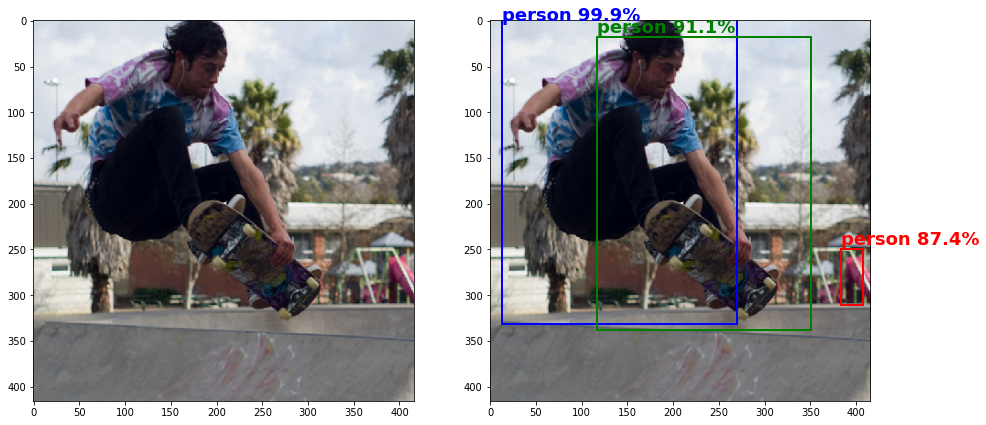

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
im = tf.cast((image[0] + 1) * 127.5, tf.int32)
#plt.rcParams['figure.figsize'] = (8,16)
fig,ax = plt.subplots(1,2,figsize=(15,15))
plt.axes(ax[0])
ax[0].imshow(im)
plt.axes(ax[1])
ax[1].imshow(im)
h, w, d = im.shape

for i in range(0, num_predictions):
    box = y_pred_nms[0][0][i].numpy()
    score = y_pred_nms[1][0][i][0].numpy()
    class_prob = y_pred_nms[2][0][i].numpy()
    values, indices = tf.math.top_k(class_prob, k=1)
    text= []
    for index, prob in zip(indices.numpy(), values.numpy()):
        text.append('{} {:.1f}%'.format(class_names[index], prob*100))
    text = ', '.join(text)
    xmin = box[0] * w
    ymin = box[1] * h
    width = (box[2] - box[0]) * w
    height = (box[3] - box[1]) * h
    color = colors[i % 8]
    rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor=color,facecolor='none')
    ax[1].add_patch(rect)
    ax[1].annotate(text, (max(xmin,0),max(ymin - 5,0)), color=color, weight='bold', 
                fontsize=18)

plt.show()

#Visualization

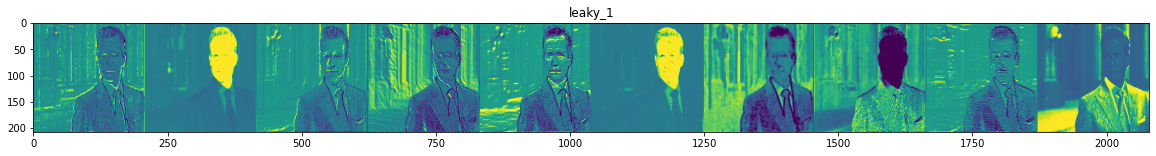

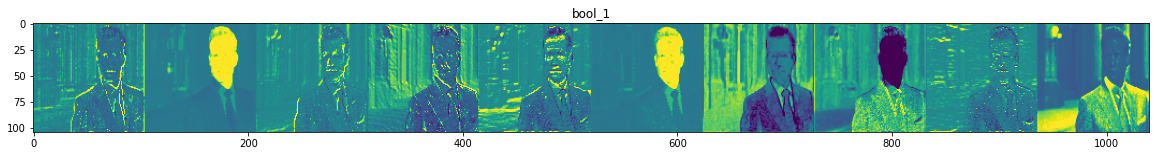

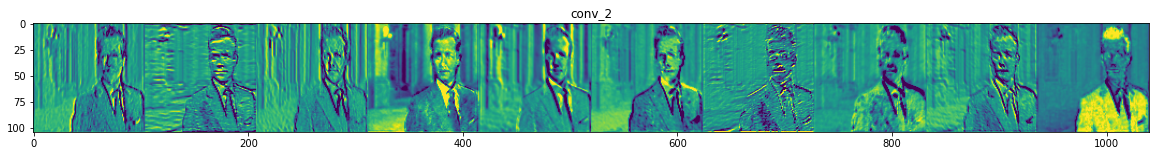

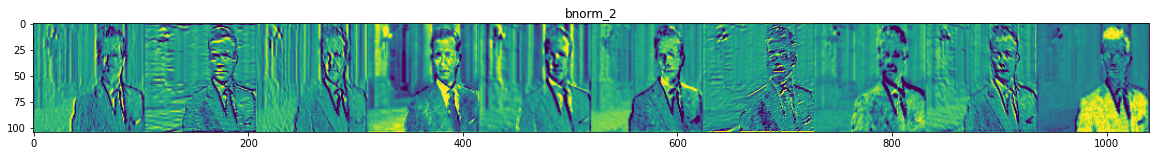

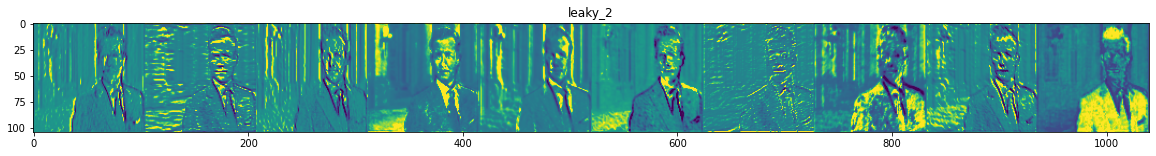

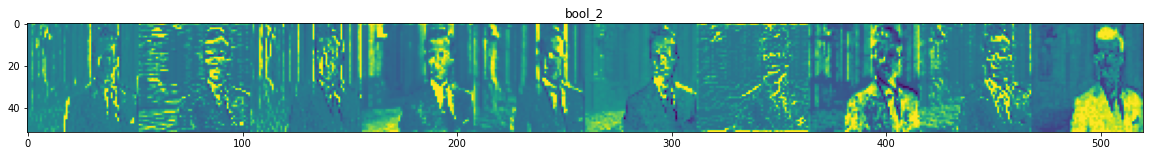

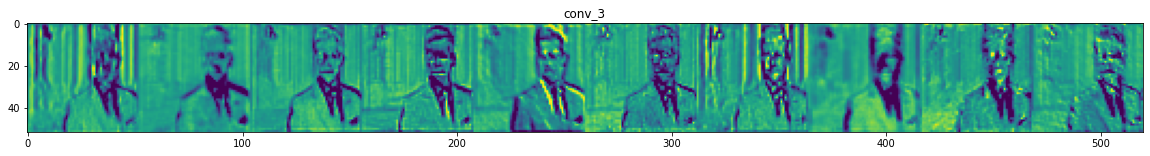

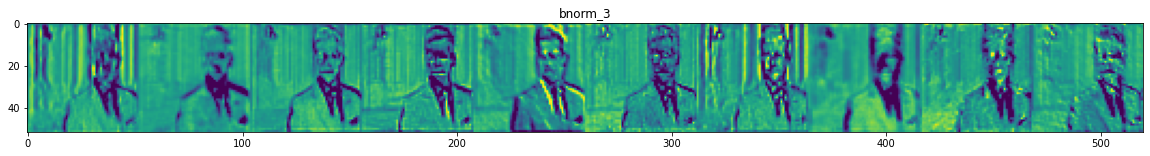

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
filename = "/content/000000001438.jpg"
#wanted layers:
start = 7
end   = 15
successive_outputs = [layer.output for layer in model.layers[start:end]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.

input_w,input_h = 416,416
x, image_w, image_h = load_image_pixels(filename, (input_w, input_h))


# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[start:end]]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * 10)) #10 instead of n_features
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(10): #10 instead of n_features
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / 10 #10 instead of n_features
    plt.figure( figsize=(scale * 10, scale) ) #10 instead of n_features
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 